In [ ]:
Lab04:
Ở bài thực hành này chúng ta sẽ thử code mạng Residual Neural Network(Resnet)
Mạng Resnet lần đầu tiên được công bố vào năm $2016$ và gần như đến nay vẫn được sử dụng vì cấu trúc của Resnet cho phép model hạn chế được vanishing gradient 

Resnet là network áp dụng identiy mapping, nghĩa là input của một số layers được chuyển trực tiếp đến một số lớp khác, ta có thể nhìn hình minh họa ở bên dưới 


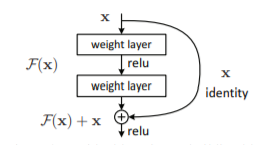

Tuy nhiên, trong thực tế ta có thể gặp một số trường hợp identity input và output có thể có kích thước khác nhau thì ta bắt buộc phải sử dụng một trick nhỏ đó là dùng convolution có kernel size là 1x1 để đưa identity input và output về đúng kích thước
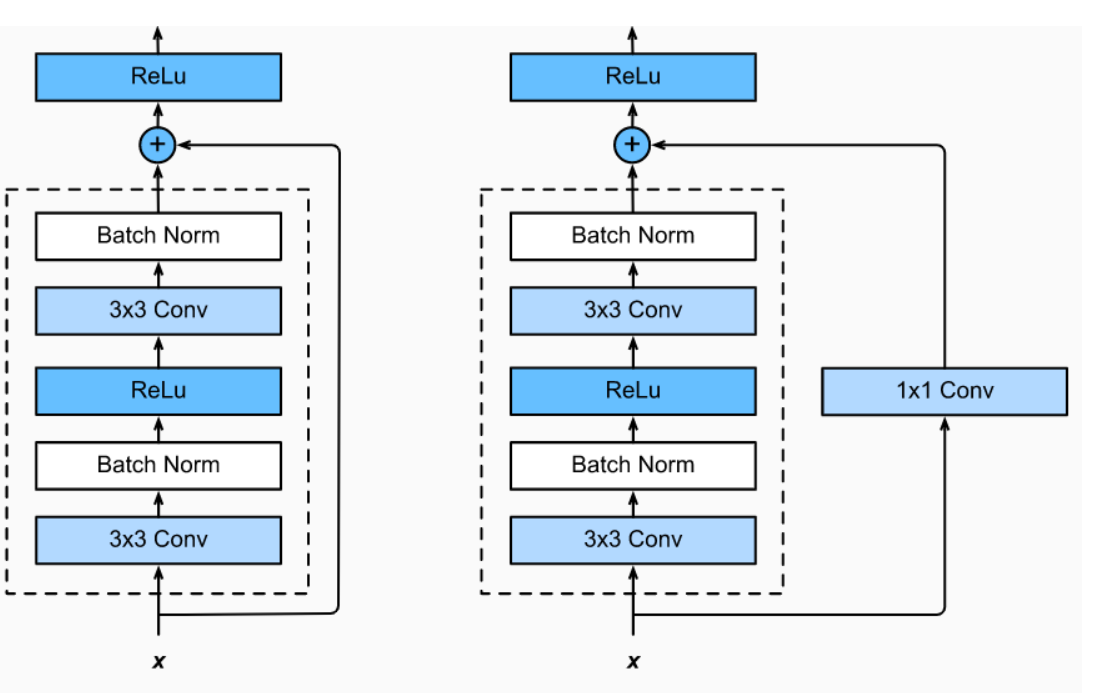

Đây là cấu trúc của từng biến thể Resnet. Trong bài thực hành này chúng ta sẽ làm việc với resnet34 và resnet50

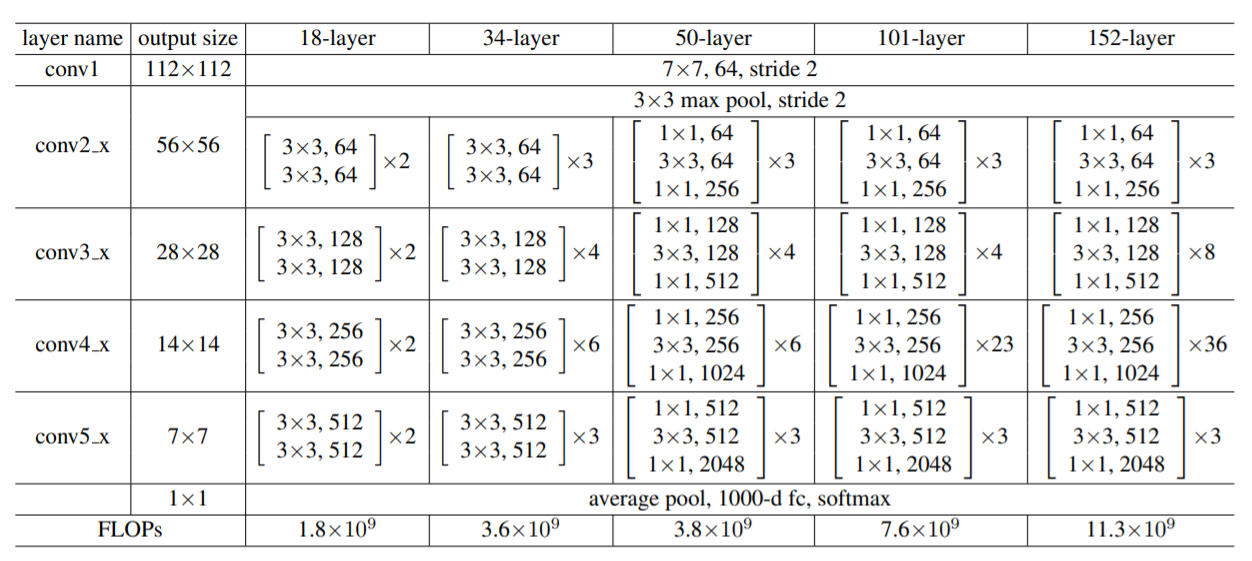

In [ ]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D

In [ ]:
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D

## Định nghĩa 1 Residual Block
class ResidualBlock(keras.layers.Layer):

    def __init__(self, n_filters=64, kernel_regularizer=None, down_sampling=False):
        ## Gọi hàm khởi tạo của keras.layers.Layer và lưu lại các thông số
        super(ResidualBlock, self).__init__()
        self.n_filters = n_filters
        self.down_sampling = down_sampling
        self.kernel_regularizer = kernel_regularizer
    
    ## override hàm này để có thể lưu file
    def get_config(self):
        ## lấy config của lớp cha
        config = super(ResidualBlock, self).get_config()
        ## thêm config của lớp này
        config.update({
            'n_filters': self.n_filters,
            "down_sampling": self.down_sampling,
        })
        return config
    
    def build(self, input_shape):
        
        ## Xác định xem input_shape có bằng output_shape không
        self.projection_shortcut = (int(input_shape[-1]) != self.n_filters) or self.down_sampling
        ## Nếu cần down sampling thì convolutional layer đầu tiên dùng strides=[2,2]
        first_strides = [1,1]
        if self.down_sampling:
            first_strides = [2,2]
        
        ##Khai báo các layer nhánh chính
        self.main_conv1 = Convolution2D(filters=self.n_filters,
                                         kernel_size=[3,3],
                                         strides=first_strides,
                                         padding='same',
                                         kernel_regularizer=self.kernel_regularizer,
                                         activation=None)
        self.main_batch1 = BatchNormalization()
        self.main_relu1 = ReLU()

        self.main_conv2 = Convolution2D(filters=self.n_filters,
                                              kernel_size=[3,3],
                                              strides=[1,1],
                                              padding='same',
                                              kernel_regularizer=self.kernel_regularizer,
                                              activation=None)
        self.main_batch2 = BatchNormalization()
        
        ## Khai báo các layer nhánh shortcut
        if self.projection_shortcut:
            self.shortcut_conv = Convolution2D(filters=self.n_filters,              ### N_FILETERS bằng N_FILTERS của output
                                                        kernel_size=[1,1],          ### KERNEL_SIZE = [1,1]
                                                        strides=first_strides,      ### STRIDES: giống STRIDES của conv đầu
                                                        padding='same',
                                                        kernel_regularizer=self.kernel_regularizer,
                                                        activation=None)
            self.shortcut_batch = BatchNormalization()

        self.main_relu2 = ReLU()

    def call(self, inputs):
        
        ## Thiết lập các input cho các layer đã khai báo
        main_conv1 = self.main_conv1(inputs)
        main_batch1 = self.main_batch1(main_conv1)
        main_relu1 = self.main_relu1(main_batch1)
        
        main_conv2 = self.main_conv2(main_relu1)
        main_batch2 = self.main_batch2(main_conv2)

        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_batch = self.shortcut_batch(shortcut_conv)
            
            ## Nếu input_shape != output_shape thì shortcut là convolutional layer
            shortcut = shortcut_batch
        else:
            ## Nếu input_shape == output_shape thì shortcut là inputs
            shortcut = inputs

        main_add = main_batch2 + shortcut

        main_relu2 = self.main_relu2(main_add)
        return main_relu2

In [ ]:
from keras.regularizers import l2
l2_regularizer_rate = 0.0001

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = keras.layers.Input(shape=(28,28,1))

### Block 1
conv1 = Convolution2D(filters=64,
                      kernel_size=[7,7],
                      strides=[2,2],
                      padding='same',
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(inputs)

batch1 = BatchNormalization()(conv1)        ## lớp tf.keras.layers.BatchNormalization()

relu1 = ReLU()(batch1)

maxpool1 = MaxPool2D(pool_size=[3,3],
                     strides=[2,2])(relu1)

### Block 2

res2_1 = ResidualBlock(n_filters=64,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(maxpool1)
res2_2 = ResidualBlock(n_filters=64,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_1)
res2_3 = ResidualBlock(n_filters=64,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_2)

### Block 3

res3_1 = ResidualBlock(n_filters=128,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_3)
res3_2 = ResidualBlock(n_filters=128,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_1)
res3_3 = ResidualBlock(n_filters=128,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_2)
res3_4 = ResidualBlock(n_filters=128,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_3)

### Block 4

res4_1 = ResidualBlock(n_filters=256,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_4)
res4_2 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_1)
res4_3 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_2)
res4_4 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_3)
res4_5 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_4)
res4_6 = ResidualBlock(n_filters=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_5)

### Block 5

res5_1 = ResidualBlock(n_filters=512,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_6)
res5_2 = ResidualBlock(n_filters=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_1)
res5_3 = ResidualBlock(n_filters=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_2)


### Block Output

avage_pool = GlobalAveragePooling2D()(res5_3)

softmax = Dense(units=10, activation='softmax')(avage_pool)

## Compile model
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    ##tự khai báo Optimizer với learning rate 10^-4
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()

Cấu trúc của model: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 64)          0         
_________________________________________________________________
residual_block (ResidualBloc (None, 6, 6, 64)          78784     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 6, 6

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


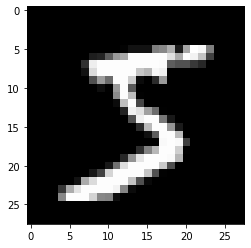

In [ ]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào trong các số từ 1 đến 10

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

#Bài Tập

Hãy code thử mạng Resnet50

Lưu ý: keras có cung cấp cho chúng ta API để gọi ra mạng Resnet

In [ ]:
tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_shape=None,
    pooling=None,
    classes=1000
)
# include_top nghĩa là thêm các lớp FC vào cuối
# weights là dùng lại pre_train ở đây đang dùng là imagenet, nếu None thì sẽ tự khởi tạo bộ weight
# input_shape là kích thước đầu vào 
# nếu include_top là false thì ta phải xác định sẽ dùng loại pooling nào để flatten